# Automatic Differentiation
:label:`sec_autograd`

Recall from :numref:`sec_calculus`
that calculating derivatives is the crucial step
in all the optimization algorithms
that we will use to train deep networks.
While the calculations are straightforward,
working them out by hand can be tedious and error-prone,
and these issues only grow
as our models become more complex.

Fortunately all modern deep learning frameworks
take this work off our plates
by offering *automatic differentiation*
(often shortened to *autograd*).
As we pass data through each successive function,
the framework builds a *computational graph*
that tracks how each value depends on others.
To calculate derivatives,
automatic differentiation
works backwards through this graph
applying the chain rule.
The computational algorithm for applying the chain rule
in this fashion is called *backpropagation*.

While autograd libraries have become
a hot concern over the past decade,
they have a long history.
In fact the earliest references to autograd
date back over half of a century :cite:`Wengert.1964`.
The core ideas behind modern backpropagation
date to a PhD thesis from 1980 :cite:`Speelpenning.1980`
and were further developed in the late 1980s :cite:`Griewank.1989`.
While backpropagation has become the default method
for computing gradients, it is not the only option.
For instance, the Julia programming language employs
forward propagation :cite:`Revels.Lubin.Papamarkou.2016`.
Before exploring methods,
let's first master the autograd package.


In [ ]:
import torch

## A Simple Function

Let's assume that we are interested
in (**differentiating the function
$y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to the column vector $\mathbf{x}$.**)
To start, we assign `x` an initial value.


In [ ]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

[**Before we calculate the gradient
of $y$ with respect to $\mathbf{x}$,
we need a place to store it.**]
In general, we avoid allocating new memory
every time we take a derivative
because deep learning requires
successively computing derivatives
with respect to the same parameters
a great many times,
and we might risk running out of memory.
Note that the gradient of a scalar-valued function
with respect to a vector $\mathbf{x}$
is vector-valued with
the same shape as $\mathbf{x}$.


In [ ]:
# Can also create x = torch.arange(4.0, requires_grad=True)
x.requires_grad_(True)
x.grad  # The gradient is None by default

(**We now calculate our function of `x` and assign the result to `y`.**)


In [ ]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

[**We can now take the gradient of `y`
with respect to `x`**] by calling
its `backward` method.
Next, we can access the gradient
via `x`'s `grad` attribute.


In [ ]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

(**We already know that the gradient of the function $y = 2\mathbf{x}^{\top}\mathbf{x}$
with respect to $\mathbf{x}$ should be $4\mathbf{x}$.**)
We can now verify that the automatic gradient computation
and the expected result are identical.


In [ ]:
x.grad == 4 * x

tensor([True, True, True, True])

[**Now let's calculate
another function of `x`
and take its gradient.**]
Note that PyTorch does not automatically
reset the gradient buffer
when we record a new gradient.
Instead, the new gradient
is added to the already-stored gradient.
This behavior comes in handy
when we want to optimize the sum
of multiple objective functions.
To reset the gradient buffer,
we can call `x.grad.zero_()` as follows:


In [ ]:
x.grad.zero_()  # Reset the gradient
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

## Backward for Non-Scalar Variables

When `y` is a vector,
the most natural representation
of the derivative of  `y`
with respect to a vector `x`
is a matrix called the *Jacobian*
that contains the partial derivatives
of each component of `y`
with respect to each component of `x`.
Likewise, for higher-order `y` and `x`,
the result of differentiation could be an even higher-order tensor.

While Jacobians do show up in some
advanced machine learning techniques,
more commonly we want to sum up
the gradients of each component of `y`
with respect to the full vector `x`,
yielding a vector of the same shape as `x`.
For example, we often have a vector
representing the value of our loss function
calculated separately for each example among
a *batch* of training examples.
Here, we just want to (**sum up the gradients
computed individually for each example**).


Because deep learning frameworks vary
in how they interpret gradients of
non-scalar tensors,
PyTorch takes some steps to avoid confusion.
Invoking `backward` on a non-scalar elicits an error
unless we tell PyTorch how to reduce the object to a scalar.
More formally, we need to provide some vector $\mathbf{v}$
such that `backward` will compute
$\mathbf{v}^\top \partial_{\mathbf{x}} \mathbf{y}$
rather than $\partial_{\mathbf{x}} \mathbf{y}$.
This next part may be confusing,
but for reasons that will become clear later,
this argument (representing $\mathbf{v}$) is named `gradient`.
For a more detailed description, see Yang Zhang's
[Medium post](https://zhang-yang.medium.com/the-gradient-argument-in-pytorchs-backward-function-explained-by-examples-68f266950c29).


In [ ]:
x.grad.zero_()
y = x * x
y.backward(gradient=torch.ones(len(y)))  # Faster: y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

## Detaching Computation

Sometimes, we wish to [**move some calculations
outside of the recorded computational graph.**]
For example, say that we use the input
to create some auxiliary intermediate terms
for which we do not want to compute a gradient.
In this case, we need to *detach*
the respective computational graph
from the final result.
The following toy example makes this clearer:
suppose we have `z = x * y` and `y = x * x`
but we want to focus on the *direct* influence of `x` on `z`
rather than the influence conveyed via `y`.
In this case, we can create a new variable `u`
that takes the same value as `y`
but whose *provenance* (how it was created)
has been wiped out.
Thus `u` has no ancestors in the graph
and gradients do not flow through `u` to `x`.
For example, taking the gradient of `z = x * u`
will yield the result `u`,
(not `3 * x * x` as you might have
expected since `z = x * x * x`).


In [ ]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

Note that while this procedure
detaches `y`'s ancestors
from the graph leading to `z`,
the computational graph leading to `y`
persists and thus we can calculate
the gradient of `y` with respect to `x`.


In [ ]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

## Gradients and Python Control Flow

So far we reviewed cases where the path from input to output
was well defined via a function such as `z = x * x * x`.
Programming offers us a lot more freedom in how we compute results.
For instance, we can make them depend on auxiliary variables
or condition choices on intermediate results.
One benefit of using automatic differentiation
is that [**even if**] building the computational graph of
(**a function required passing through a maze of Python control flow**)
(e.g., conditionals, loops, and arbitrary function calls),
(**we can still calculate the gradient of the resulting variable.**)
To illustrate this, consider the following code snippet where
the number of iterations of the `while` loop
and the evaluation of the `if` statement
both depend on the value of the input `a`.


In [ ]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

Below, we call this function, passing in a random value, as input.
Since the input is a random variable,
we do not know what form
the computational graph will take.
However, whenever we execute `f(a)`
on a specific input, we realize
a specific computational graph
and can subsequently run `backward`.


In [ ]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

Even though our function `f` is, for demonstration purposes, a bit contrived,
its dependence on the input is quite simple:
it is a *linear* function of `a`
with piecewise defined scale.
As such, `f(a) / a` is a vector of constant entries
and, moreover, `f(a) / a` needs to match
the gradient of `f(a)` with respect to `a`.


In [ ]:
a.grad == d / a

tensor(True)

Dynamic control flow is very common in deep learning.
For instance, when processing text, the computational graph
depends on the length of the input.
In these cases, automatic differentiation
becomes vital for statistical modeling
since it is impossible to compute the gradient *a priori*.

## Discussion

You have now gotten a taste of the power of automatic differentiation.
The development of libraries for calculating derivatives
both automatically and efficiently
has been a massive productivity booster
for deep learning practitioners,
liberating them so they can focus on less menial.
Moreover, autograd lets us design massive models
for which pen and paper gradient computations
would be prohibitively time consuming.
Interestingly, while we use autograd to *optimize* models
(in a statistical sense)
the *optimization* of autograd libraries themselves
(in a computational sense)
is a rich subject
of vital interest to framework designers.
Here, tools from compilers and graph manipulation
are leveraged to compute results
in the most expedient and memory-efficient manner.

For now, try to remember these basics: (i) attach gradients to those variables with respect to which we desire derivatives; (ii) record the computation of the target value; (iii) execute the backpropagation function; and  (iv) access the resulting gradient.


## Exercises

1. Why is the second derivative much more expensive to compute than the first derivative?
1. After running the function for backpropagation, immediately run it again and see what happens. Investigate.
1. In the control flow example where we calculate the derivative of `d` with respect to `a`, what would happen if we changed the variable `a` to a random vector or a matrix? At this point, the result of the calculation `f(a)` is no longer a scalar. What happens to the result? How do we analyze this?
1. Let $f(x) = \sin(x)$. Plot the graph of $f$ and of its derivative $f'$. Do not exploit the fact that $f'(x) = \cos(x)$ but rather use automatic differentiation to get the result.
1. Let $f(x) = ((\log x^2) \cdot \sin x) + x^{-1}$. Write out a dependency graph tracing results from $x$ to $f(x)$.
1. Use the chain rule to compute the derivative $\frac{df}{dx}$ of the aforementioned function, placing each term on the dependency graph that you constructed previously.
1. Given the graph and the intermediate derivative results, you have a number of options when computing the gradient. Evaluate the result once starting from $x$ to $f$ and once from $f$ tracing back to $x$. The path from $x$ to $f$ is commonly known as *forward differentiation*, whereas the path from $f$ to $x$ is known as backward differentiation.
1. When might you want to use forward, and when backward, differentiation? Hint: consider the amount of intermediate data needed, the ability to parallelize steps, and the size of matrices and vectors involved.


为什么计算二阶导数比计算一阶导数昂贵得多？答案：计算一阶导数时，只需要沿着计算图应用一次链式法则来计算梯度。而计算二阶导数时，需要先计算一阶导数，这已经涉及到一次沿着计算图的反向传播。然后，为了计算二阶导数，需要再次对一阶导数的结果进行反向传播。这意味着计算二阶导数需要两次沿着计算图的反向传播，并且在计算过程中需要保存更多的中间变量和梯度信息，以支持第二次反向传播。所以，计算二阶导数比计算一阶导数需要更多的计算资源和内存，因此更加昂贵。运行反向传播函数后，立即再次运行它，看看会发生什么。进行调查。答案：在 PyTorch 中，默认情况下，梯度是累加的。当我们运行一次反向传播函数后，梯度会被计算并存储在变量的grad 属性中。如果立即再次运行反向传播函数，新计算的梯度会被累加到之前存储的梯度上。例如，对于变量x，第一次反向传播计算出的梯度为\(grad_1\)，第二次反向传播计算出的梯度为\(grad_2\)，那么第二次运行后\(x.grad = grad_1 + grad_2\)。这是因为 PyTorch 为了支持对多个目标函数的梯度累加（例如在多任务学习或优化多个损失函数的和时），不会自动在每次反向传播后重置梯度。如果不希望梯度累加，可以在每次反向传播之前调用\(x.grad.zero_()\) 来重置梯度。在我们计算d 关于a 的导数的控制流示例中，如果我们将变量a 更改为随机向量或矩阵，会发生什么？此时，计算\(f(a)\) 的结果不再是标量。结果会怎样？我们如何分析这个？答案：当a 是随机向量或矩阵时，由于\(f(a)\) 的结果不再是标量，直接调用\(d.backward()\) 会引发错误。这是因为 PyTorch 要求在对非标量变量调用backward 时，需要明确指定一个gradient 参数，以告知如何将非标量的结果缩放到标量，从而计算梯度。我们可以通过提供一个与d 形状相同的向量作为gradient 参数来解决这个问题，例如\(d.backward(gradient = torch.ones_like(d))\)。这样做相当于对d 的每个元素分别计算梯度，然后将这些梯度按照gradient 中对应元素的权重进行加权求和（在这里权重都为1），最终得到关于a 的梯度。从分析的角度看，此时得到的梯度是一个与a 形状相同的张量，它反映了\(f(a)\) 的各个元素对a 的各个元素的综合影响。

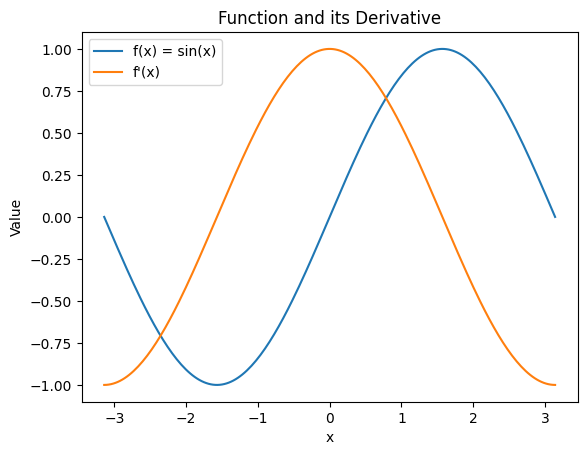

In [2]:
import torch
import matplotlib.pyplot as plt

# 生成数据
x = torch.linspace(-torch.pi, torch.pi, 200, requires_grad=True)
y = torch.sin(x)

# 计算导数
y.backward(torch.ones_like(x))
dy_dx = x.grad

# 绘图
plt.plot(x.detach().numpy(), y.detach().numpy(), label='f(x) = sin(x)')
plt.plot(x.detach().numpy(), dy_dx.detach().numpy(), label="f'(x)")
plt.xlabel('x')
plt.ylabel('Value')
plt.title("Function and its Derivative")
plt.legend()
plt.show()

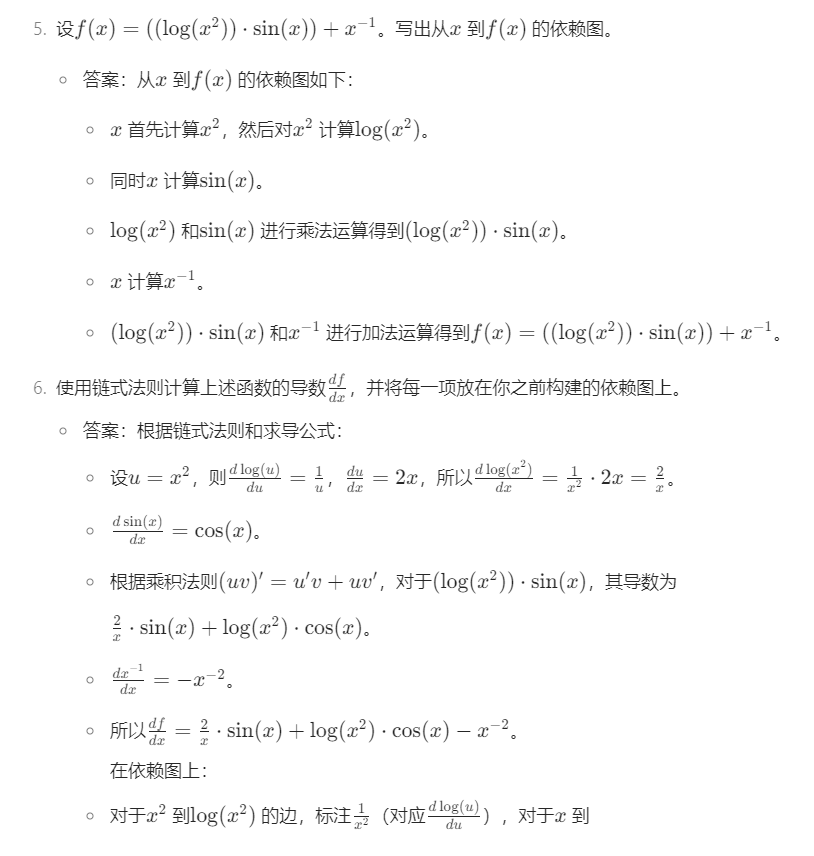

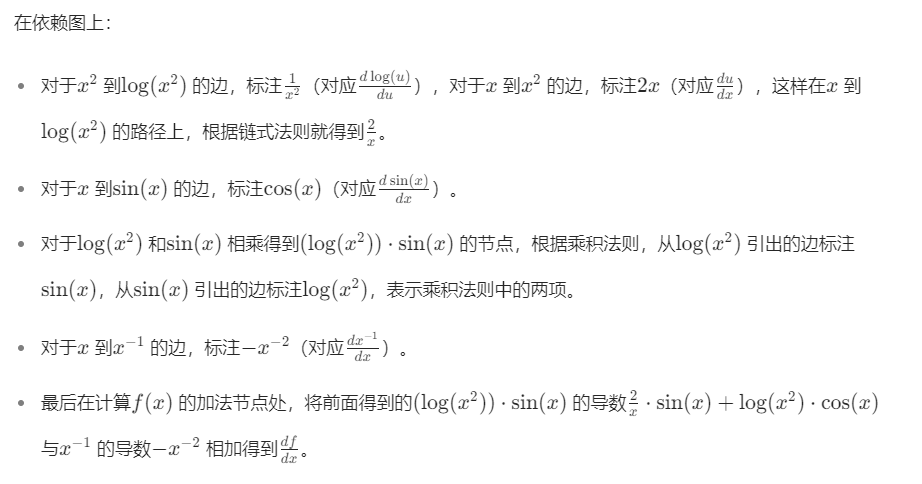

给定图和中间导数结果，在计算梯度时你有多种选择。从x 到f 计算一次结果，再从f 往回追溯到x 计算一次结果。从x 到f 的路径通常称为前向求导，而从f 到x 的路径称为反向求导。答案：前向求导：从x 开始，按照依赖图逐步计算中间结果及其导数。先计算\(x^2\)，再计算\(\log(x^2)\) 并得到其导数\(\frac{2}{x}\)，计算\(\sin(x)\) 并得到其导数\(\cos(x)\)，根据乘积法则计算\((\log(x^2)) \cdot \sin(x)\) 的导数\(\frac{2}{x} \cdot \sin(x) + \log(x^2) \cdot \cos(x)\)，计算\(x^{-1}\) 并得到其导数\(-x^{-2}\)，最后将这些结果组合起来得到\(\frac{df}{dx}=\frac{2}{x} \cdot \sin(x) + \log(x^2) \cdot \cos(x) - x^{-2}\)。在这个过程中，需要依次计算每个中间节点的导数，并且随着计算的进行，需要记住前面计算的中间结果及其导数，以便后续计算使用。反向求导（反向传播）：从\(f(x)\) 开始，根据链式法则逐步往回追溯计算梯度。先将\(f(x)\) 看作是由\((\log(x^2)) \cdot \sin(x)\) 和\(x^{-1}\) 相加得到的，那么\(f(x)\) 关于\((\log(x^2)) \cdot \sin(x)\) 和\(x^{-1}\) 的导数分别为1。然后对于\((\log(x^2)) \cdot \sin(x)\)，根据乘积法则往回追溯，得到关于\(\log(x^2)\) 和\(\sin(x)\) 的导数，再分别对\(\log(x^2)\) 和\(\sin(x)\) 继续根据链式法则往回追溯到x，计算出相应的导数。对于\(x^{-1}\) 也往回追溯到x 计算其导数。最终得到\(\frac{df}{dx}\)。反向求导在计算过程中可以更有效地利用中间结果，避免了一些重复计算，特别是在复杂的计算图中，当有很多共享的中间节点时，反向求导可以减少计算量和内存消耗。什么时候你可能想使用前向求导，什么时候使用反向求导？提示：考虑所需的中间数据量、并行化步骤的能力以及涉及的矩阵和向量的大小。答案：使用前向求导的情况：当计算图比较简单，中间节点和边较少，且不需要共享中间计算结果时，前向求导可能更直观和简单。因为前向求导按照正常的计算顺序进行，逻辑相对清晰，容易理解和实现。如果需要计算的是函数在某一点的导数，并且函数的计算过程本身比较简单，不需要多次重复计算导数（例如只计算一次导数），前向求导可能是一个不错的选择，因为它不需要像反向求导那样构建复杂的反向传播路径。当涉及的矩阵和向量维度较小，计算量不大时，前向求导在内存和计算时间上的开销可能相对较小，因为它不需要存储大量的中间梯度信息用于反向传播。如果有很好的并行计算环境，并且可以有效地并行计算每个中间节点的导数，前向求导可以充分利用并行计算的优势，提高计算效率。因为前向求导在计算每个中间节点的导数时相对独立，可以并行处理。使用反向求导的情况：在深度学习中，当模型的计算图非常复杂，包含大量的中间层和参数时，反向求导（反向传播）是计算梯度的主要方法。因为反向求导可以避免重复计算，通过一次反向传播就可以计算出所有参数的梯度，大大减少了计算量和内存消耗。例如在深度神经网络中，参数数量众多，如果使用前向求导计算梯度，会导致大量的重复计算，而反向求导可以高效地利用中间结果来计算梯度。当需要多次计算函数关于不同输入的导数时，反向求导更具优势。因为反向求导构建的计算图可以在不同输入下重复使用，只需要根据新的输入重新计算前向传播的结果，然后进行反向传播即可得到新的梯度，而不需要重新计算整个导数。当涉及的矩阵和向量维度较大时，反向求导可以更好地管理内存。因为反向求导是从输出往输入反向计算梯度，不需要像前向求导那样在整个计算过程中都保存所有中间结果的导数，只需要在反向传播过程中逐步计算和使用梯度信息，从而减少内存占用。如果计算过程中存在大量共享的中间计算结果（例如在神经网络的隐藏层中，很多神经元的计算会共享一些中间变量），反向求导可以更有效地利用这些共享结果，避免重复计算，提高计算效率。

[Discussions](https://discuss.d2l.ai/t/35)
